## Lib Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, accuracy_score


## File Declaration

In [2]:
train_file = "dos.csv"
test_file = "dos_test.csv"

## Data Prep and Feature Eng

In [5]:
# Calculate variance features
def calculate_variance_features(df, window_size):
    for col in ['seconds']:
        df[f'{col}_variance'] = df[col].rolling(window=window_size).var()
    return df

# Calculate standard deviation features
def calculate_std_features(df, window_size):
    for col in ['seconds']:
        df[f'{col}_std'] = df[col].rolling(window=window_size).std()
    return df

# Calculate range features
def calculate_range_features(df, window_size):
    for col in ['seconds']:
        df[f'{col}_range'] = df[col].rolling(window=window_size).max() - df[col].rolling(window=window_size).min()
    return df

# Calculate entropy features
def calculate_entropy_features(df, window_size):
    for col in ['seconds']:
        def entropy(signal):
            _, counts = np.unique(signal, return_counts=True)
            probs = counts / len(signal)
            return - np.sum(probs * np.log2(probs))
        df[f'{col}_entropy'] = df[col].rolling(window=window_size).apply(entropy)
    return df

# Load the data
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Convert 'Timestamp' column to datetime format
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'])
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'])

# Create a new column with just the seconds
train_data['seconds'] = train_data['Timestamp'].dt.second
test_data['seconds'] = test_data['Timestamp'].dt.second

# Add features to train and test data
window_size = 20
train_data = calculate_variance_features(train_data, window_size)
train_data = calculate_std_features(train_data, window_size)

test_data = calculate_variance_features(test_data, window_size)
test_data = calculate_std_features(test_data, window_size)

# Drop it since we want only to catch if there are more packets
train_data.drop(['Timestamp', 'y1', 'y2', 'y3', 'V12', 'V23', 'seconds'], axis=1, inplace=True)
test_data.drop(['Timestamp', 'y1', 'y2', 'y3', 'V12', 'V23', 'seconds'], axis=1, inplace=True)

# Drop rows with NaN values resulting from shifting
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

X_train = train_data.drop(columns=['label'])
y_train = train_data['label']
X_test = test_data.drop(columns=['label'])
y_test = test_data['label']

# Initialize the scaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train and Eval

Logistic Regression	0.85	0.00	0.00	0.00	0.50
Random Forest	0.96	0.91	0.78	0.84	0.88
Gradient Boosting	0.96	0.91	0.79	0.85	0.89


c:\Users\Alessio\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


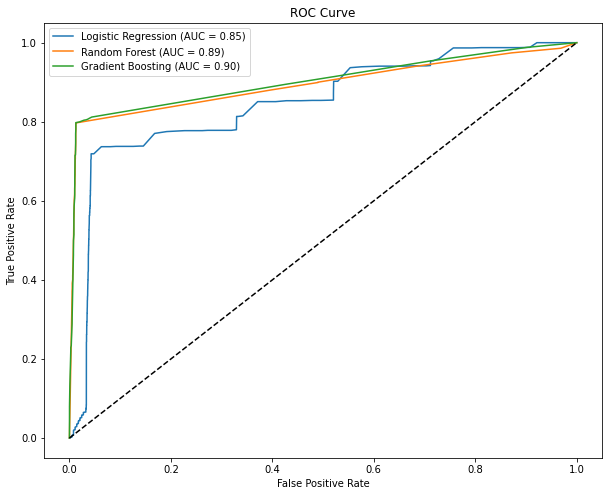

In [6]:
# Initialize models
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100)
gb = GradientBoostingClassifier(n_estimators=100)

# Train models
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_gb = gb.predict(X_test)

# Evaluation
def evaluate_model(y_test, y_pred, model_name):
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    #print(f"{model_name} Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, AUC: {auc:.2f}")
    print(f"{model_name}\t{accuracy:.2f}\t{precision:.2f}\t{recall:.2f}\t{f1:.2f}\t{auc:.2f}")
    
evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_gb, "Gradient Boosting")

# ROC Curve
def plot_roc_curve(model, X_test, y_test, model_name):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")
    
plt.figure(figsize=(10, 8))
plot_roc_curve(lr, X_test, y_test, "Logistic Regression")
plot_roc_curve(rf, X_test, y_test, "Random Forest")
plot_roc_curve(gb, X_test, y_test, "Gradient Boosting")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## Viz test results

In [ ]:
# Assuming 'test_file' and 'window_size' are defined
dft = pd.read_csv(test_file)
dft['Timestamp'] = pd.to_datetime(dft['Timestamp'], format='%d-%b-%Y %H:%M:%S')
dft = dft.iloc[window_size-1:]  # Remove window initial data
label_dft = dft[dft['label'] == 1]
ranges = []

# Find contiguous ranges of true labels
start = None
for i in range(len(label_dft)):
    if start is None:
        start = label_dft['Timestamp'].iloc[i]
    if i == len(label_dft) - 1 or label_dft['Timestamp'].iloc[i] != label_dft['Timestamp'].iloc[i + 1]:
        end = label_dft['Timestamp'].iloc[i]
        ranges.append((start, end))
        start = None

# Find contiguous ranges of predicted labels
dft['pred'] = y_pred_rf  # Assuming 'y_pred_rf' is defined
label_dft_pred = dft[dft['pred'] == 1]
rangesTest = []
start = None
for i in range(len(label_dft_pred)):
    if start is None:
        start = label_dft_pred['Timestamp'].iloc[i]
    if i == len(label_dft_pred) - 1 or label_dft_pred['Timestamp'].iloc[i] != label_dft_pred['Timestamp'].iloc[i + 1]:
        end = label_dft_pred['Timestamp'].iloc[i]
        rangesTest.append((start, end))
        start = None

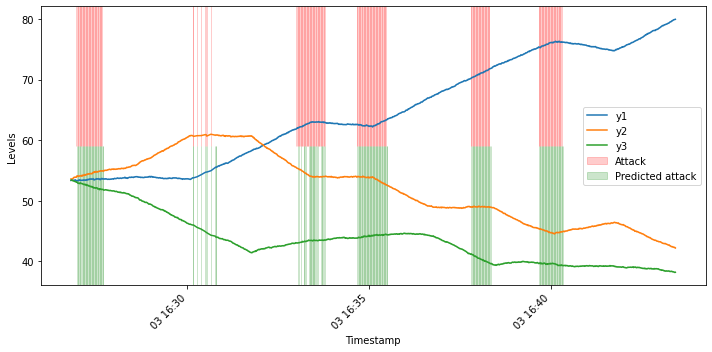

In [ ]:
# Define pastel colors
pastel_colors = sns.color_palette("Set2", 5)

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# First row
sns.lineplot(x='Timestamp', y='y1', data=dft, ax=ax, label='y1', )
sns.lineplot(x='Timestamp', y='y2', data=dft, ax=ax, label='y2', )
sns.lineplot(x='Timestamp', y='y3', data=dft, ax=ax, label='y3', )

for start, end in ranges:
    ax.axvspan(start, end, 0.5, 1, alpha=0.2, color="red")

for start, end in rangesTest:
    ax.axvspan(start, end, 0, 0.5, alpha=0.2, color="green")

attack_patch = Patch(color='red', alpha=0.2, label='Attack')
attack_pred_patch = Patch(color='green', alpha=0.2, label='Predicted attack')
handles, labels = ax.get_legend_handles_labels()
handles.append(attack_patch)
handles.append(attack_pred_patch)
labels.append('Attack')
labels.append('Predicted attack')
ax.legend(handles=handles, labels=labels)
ax.set_ylabel("Levels")

# Adjusting the x-axis format
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

# Adjust layout
plt.tight_layout()
plt.show()
